- mimic lateral water flow   
- after firn, lid and lake functions are called 

- if cell["lake"]:
        cell["lake_depth"] += cell['fmeltwater']*3/24
- reset to zero after cell['fmeltwater']= 0

- lid grows year-on-year because  

- Questions:
- 1. Why does lid not shrink by surface melting if lid_depth > 10 cm deep ? 
- 2. Is the hack added in in the correct place in the code (timesteps.py)
- 3. Should melt water be added if a lid is present or not 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import matplotlib.dates as mdates

expt_id = 'era5_2013_2024_05'
start_time = pd.Timestamp('2013-01-01 00:00')

output_filepath = '1d_testcase_output_' + expt_id + '.nc' 
met_filepath    = '1d_testcase_met_'+ expt_id + '.nc'
dump_filepath   = '1d_testcase_dump_' + expt_id + '.nc' 

met = nc.Dataset(met_filepath, 'r')
output = nc.Dataset(output_filepath, 'r')
dump = nc.Dataset(dump_filepath, 'r')

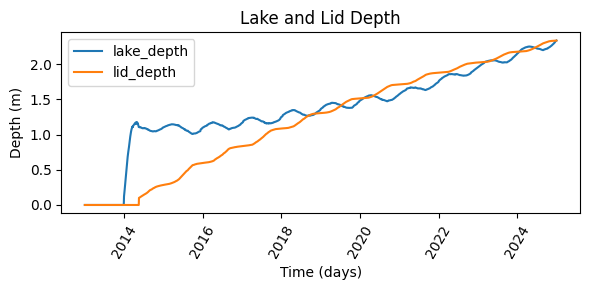

Max lake depth: 2.34 m
Max lid depth: 2.34 m


In [30]:
lake_vars = ['lake_depth', 'lid_depth']
lake_units = ['m', 'm']

time_day = pd.date_range(start=start_time, periods=len(output.variables['lake_depth'][:, 0, 0]), freq='d')

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for var_name, unit in zip(lake_vars, lake_units):
    data = output.variables[var_name][:, 0, 0]
    ax.plot(time_day, data, label=var_name)

ax.set_title('Lake and Lid Depth')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time (days)')
ax.tick_params(axis='x', rotation=60)
ax.legend()

plt.tight_layout()
plt.show()

lake_max = output.variables['lake_depth'][:, 0, 0].max()
lid_max = output.variables['lid_depth'][:, 0, 0].max()

print(f"Max lake depth: {lake_max:.2f} m")
print(f"Max lid depth: {lid_max:.2f} m")


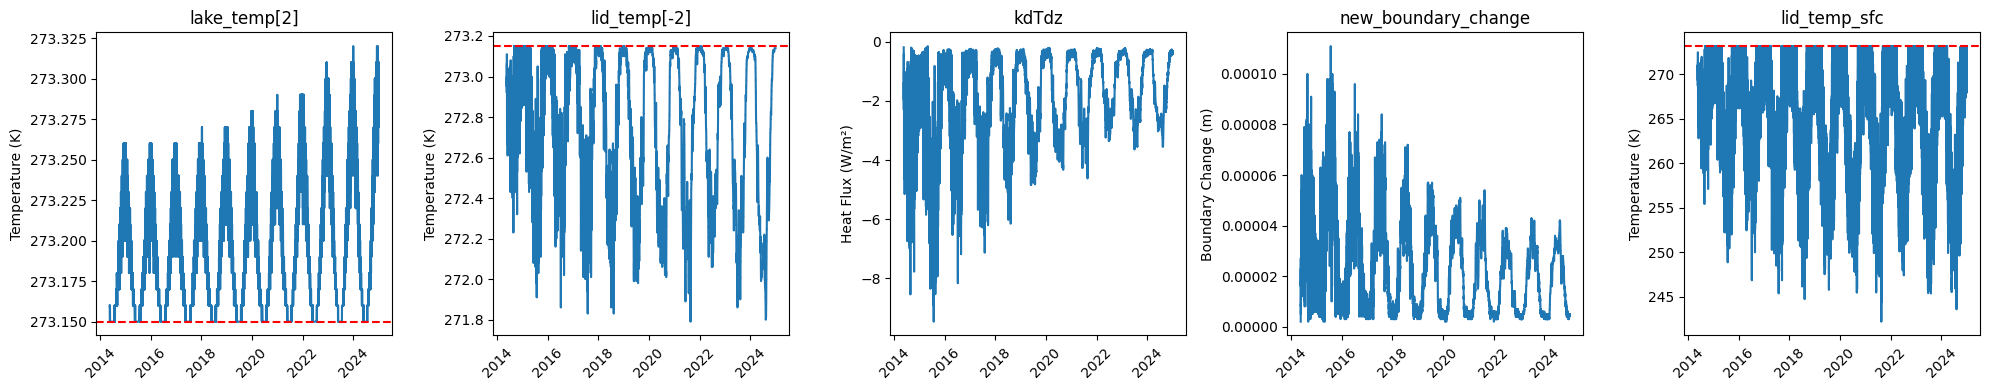

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the column names
column_names = ["day", "t_step", "lake_depth", "lid_depth", "lid_temp_sfc", "kdTdz", "new_boundary_change", "lake_temp[2]", "lid_temp[-2]"]
column_units = {
    "lid_temp_sfc": "Temperature (K)",
    "kdTdz": "Heat Flux (W/m²)",
    "new_boundary_change": "Boundary Change (m)",
    "lake_temp[2]": "Temperature (K)",
    "lid_temp[-2]": "Temperature (K)"
}

# Load the file
df = pd.read_csv("lid_log_era5_2013_2024_06.txt", sep=r"\s+", header=None, names=column_names)

# Create datetime index
df["time"] = df["day"] + df["t_step"] / 24
df["datetime"] = pd.to_datetime("2013-01-01") + pd.to_timedelta(df["time"], unit="D")

# Columns to plot
plot_columns = ["lake_temp[2]", "lid_temp[-2]", "kdTdz", "new_boundary_change", "lid_temp_sfc",]

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharex=True)
for ax, col in zip(axes, plot_columns):
    ax.plot(df["datetime"], df[col])
    ax.set_ylabel(column_units[col])
    ax.set_title(col)
    if col in ["lid_temp_sfc", "lake_temp[2]", "lid_temp[-2]"]:
        ax.axhline(273.15, color='red', linestyle='--')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# permanent lid depth is controlled by lake - lid temp difference 
#kdTdz = (
#        (-cell["lake_temperature"][2] + cell["lid_temperature"][-2])
#        * abs(cell["k_water"])
#        / (
#            cell["lake_depth"] / cell["vert_grid_lake"]
#            + cell["lid_depth"] / cell["vert_grid_lid"]
#        )
#    )
#    new_boundary_change = -kdTdz / (cell["L_ice"] * cell["rho_ice"]) * dt

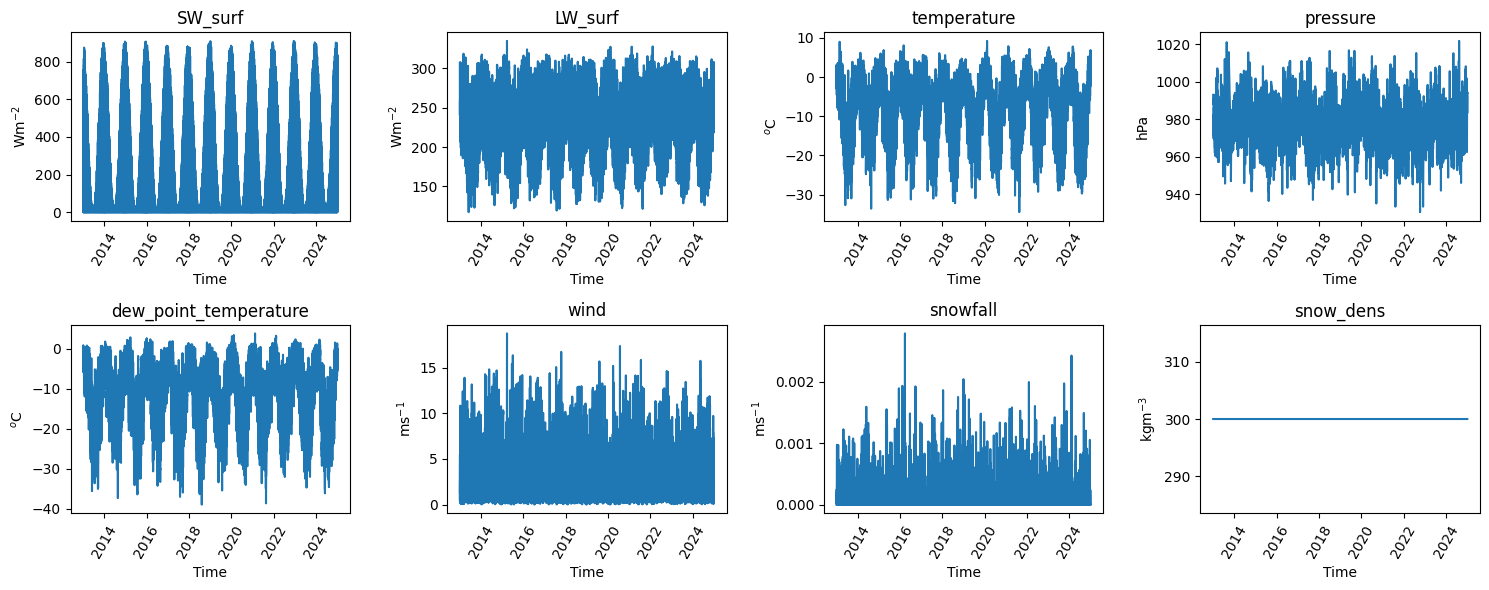

In [22]:
met_vars = ['SW_surf', 'LW_surf', 'temperature', 'pressure',
            'dew_point_temperature', 'wind', 'snowfall', 'snow_dens']
met_units = ['Wm$^{-2}$', 'Wm$^{-2}$', '$^{o}$C', 'hPa',
             '$^{o}$C', 'ms$^{-1}$', 'ms$^{-1}$', 'kgm$^{-3}$']

fig, axes = plt.subplots(2, 4, figsize=(15, 6)) # w, h
axes = axes.flatten()

for i, var_name in enumerate(met_vars):
    ax = axes[i]
    data = met.variables[var_name][:, 0, 0]

    time_hr = pd.date_range(start=start_time, periods=len(data), freq='h')

    if var_name in ['temperature', 'dew_point_temperature']:
        data = data - 273.15

    ax.plot(time_hr, data)
    ax.set_title(var_name)
    ax.set_ylabel(met_units[i])
    ax.set_xlabel('Time')
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

n_hrs = len(time_hr)
n_days = int(n_hrs/24)

In [23]:
vertical_depth = dump.variables['vertical_profile'][0:,0, :]
vertical_depth = vertical_depth.squeeze() 

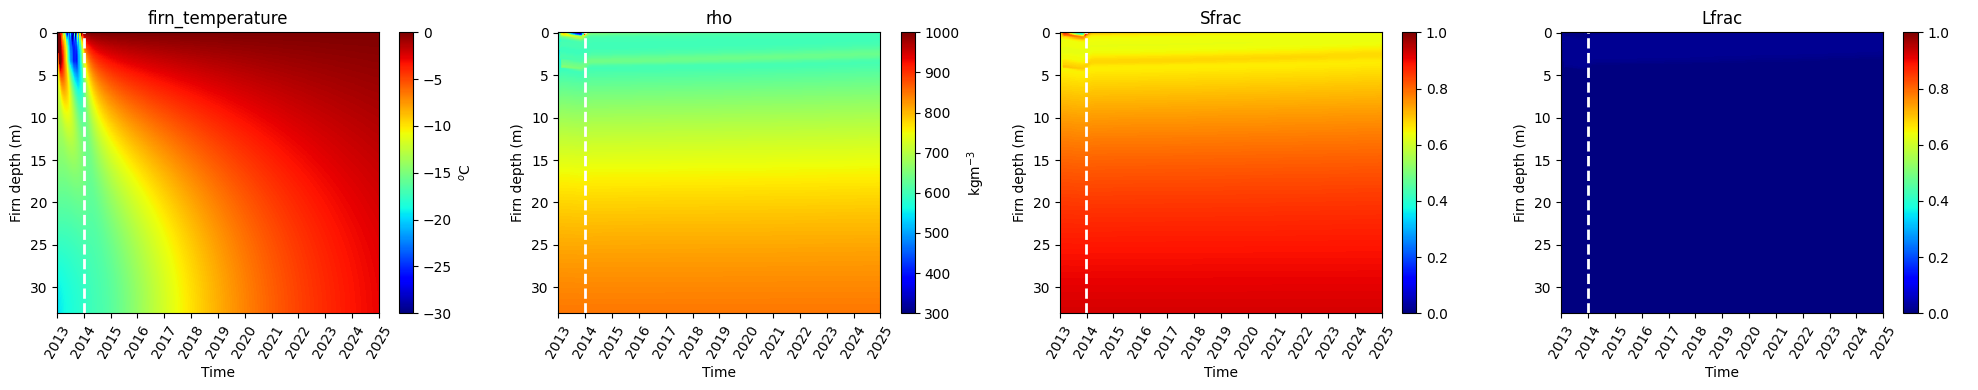

In [24]:
# 2d variables
firn_2d_vars  = ['firn_temperature', 'rho',     'Sfrac', 'Lfrac' ]
firn_2d_units = ['$^{o}$C',          'kgm$^{-3}$', ' ', ' ' ]
firn_2d_min   = [-30,                 300,      0,      0] 
firn_2d_max   = [0,                   1000,     1,      1]  


fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes = axes.flatten()

# check when/if a lake is formed
lake = output.variables['lake'][:, 0, 0]

# set up time in days
time_day = pd.date_range(start=start_time, periods=len(lake), freq='d')

islake = np.where(lake == 1)[0]

if islake.size > 0:
    start_lake_index = islake[0]
    end_lake_index = islake[-1] + 1
else:
    print('Lake did not form.')


for i, var_name in enumerate(firn_2d_vars):
    ax = axes[i]
    data_2d = output.variables[var_name][:, 0, 0, :]  
    
    if var_name == 'firn_temperature': data_2d -= 273.15
    im = ax.pcolormesh(time_day, vertical_depth, data_2d.T, shading='auto', 
                       cmap='jet', vmin=firn_2d_min[i],vmax=firn_2d_max[i])
    
    ax.axvline(x=time_day[start_lake_index], color='white', linestyle='--', linewidth=2)
    #ax.axvline(x=time_day[first_lake_index + lake_days_true-1], color='white', linestyle='--', linewidth=2) 
    plt.colorbar(im, ax=ax, label=firn_2d_units[i])
    ax.set_title(var_name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Firn depth (m)')
    ax.invert_yaxis()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

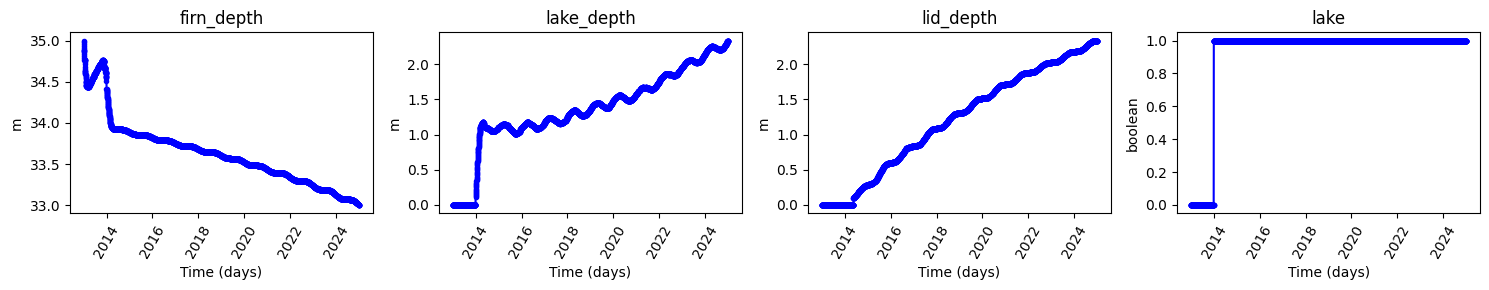

In [25]:
firn_1d_vars = ['firn_depth', 'lake_depth', 'lid_depth','lake']
firn_1d_units = ['m', 'm', 'm' ,'boolean']


time_day = pd.date_range(start=start_time, periods=len(lake), freq='d')

fig, axes = plt.subplots(1, 4, figsize=(15, 3)) # w, h
axes = axes.flatten()

for i, var_name in enumerate(firn_1d_vars):
    ax = axes[i]
    data = output.variables[var_name][:, 0, 0]
    time = np.arange(len(data))
    
    ax.plot(time_day, data, 'b.-')
    ax.set_title(var_name)
    ax.set_ylabel(firn_1d_units[i])
    ax.set_xlabel('Time (days)')
    ax.tick_params(axis='x', rotation=60)
plt.tight_layout()
plt.show()

#print(start_lake_index, end_lake_index)

#print(output.variables['rho'][start_lake_index, 0, 0, 0:10])
#print(output.variables['rho'][end_lake_index-1, 0, 0, 0:10])

#print(output.variables['lid_depth'][start_lake_index:end_lake_index, 0, 0])
#print(output.variables['lake_depth'][start_lake_index:end_lake_index, 0, 0])

In [26]:
lake_depth = output.variables['lake_depth'][:, 0, 0]
lid_depth = output.variables['lid_depth'][:, 0, 0]
lake = output.variables['lake'][:, 0, 0]

df = pd.DataFrame({
    'date': time_day,
    'lake_depth_m': lake_depth,
    'lid_depth_m': lid_depth,
    'lake_bool': lake.astype(int)  # assuming lake is boolean; convert to 0/1
})

df.to_csv('lake_lid_depths.csv', index=False)


In [27]:
# Print all constant values 
print_dump_const = False  

if print_dump_const:
    
    print('Constant variables written to dump:')
    for var in dump.variables:
        dims = dump.variables[var].dimensions
        if dims == ('x', 'y'):
            value = dump.variables[var][0, 0]
            print(f'{var:25s}: {value}')

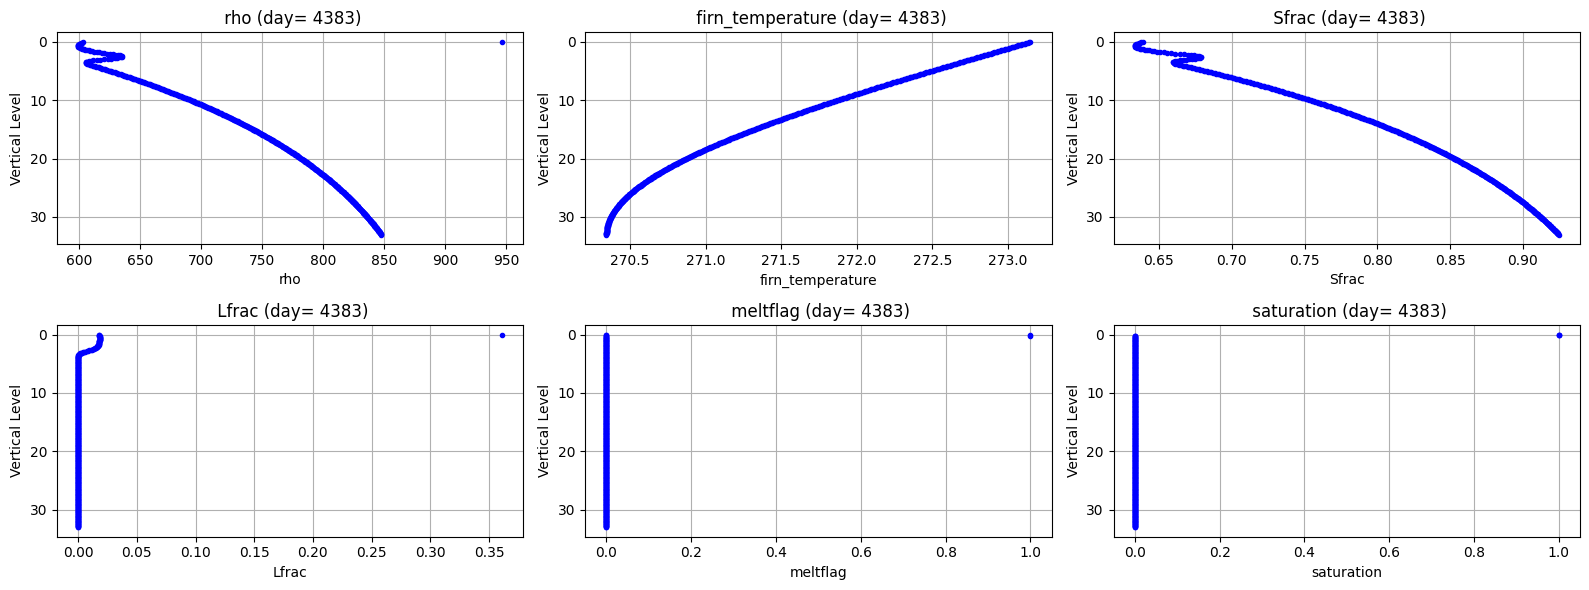

In [28]:
# --- plot vars that are a function of model level
vars_to_plot = [var for var in dump.variables 
                if dump.variables[var].dimensions == ('x', 'y', 'vert_grid')][1:-1]

fig, axes = plt.subplots(2, 3, figsize=(16, 6))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot[:8]):  
    data = dump.variables[var][:]           
    profile = data[0, 0, :]                
    
    ax = axes[i]
    ax.plot(profile, vertical_depth, 'b.')
    ax.set_title(f' {var} (day= {n_days})')

#    ax.set_title(var)
    ax.set_xlabel(var)
    ax.set_ylabel('Vertical Level')
    ax.invert_yaxis()
    ax.grid(True)

plt.tight_layout()
plt.show()


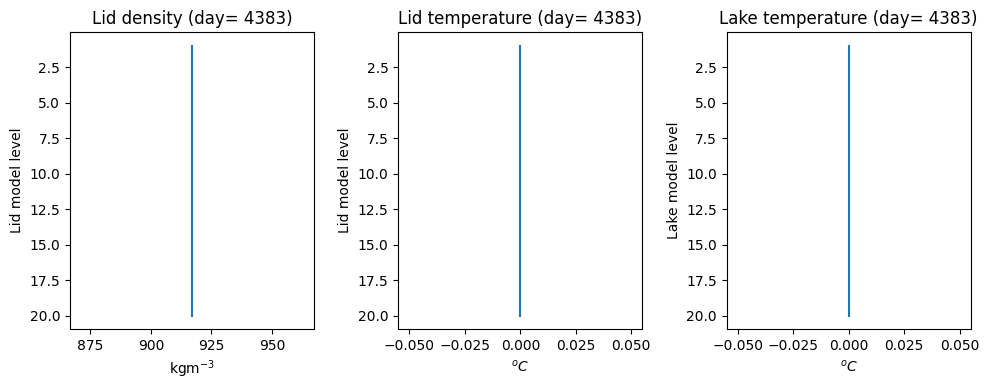

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = axes.flatten()

vertical_grid_lid = int(dump.variables['vert_grid_lid'][:])
vertical_grid_lake = int(dump.variables['vert_grid_lake'][:])
rho_lid = dump.variables['rho_lid'][0,0,:]    
lid_temperature = dump.variables['lid_temperature'][0,0,:] 
lake_temperature = dump.variables['lake_temperature'][0,0,:] 


ax = axes[0]
ax.plot(rho_lid, range(1, vertical_grid_lid + 1) )
ax.set_title(f'Lid density (day= {n_days})')
ax.set_xlabel('kgm$^{-3}$')
ax.set_ylabel('Lid model level')
ax.invert_yaxis()  

ax = axes[1]
ax.plot(lid_temperature-273.15, range(1, vertical_grid_lid + 1) )
ax.set_title(f'Lid temperature (day= {n_days})')
ax.set_xlabel('$^{o}C$')
ax.set_ylabel('Lid model level')
ax.invert_yaxis()  

ax = axes[2]
ax.plot(lake_temperature-273.15, range(1, vertical_grid_lake + 1) )
ax.set_title(f'Lake temperature (day= {n_days})')
ax.set_xlabel('$^{o}C$')
ax.set_ylabel('Lake model level')
ax.invert_yaxis()  

plt.tight_layout()
plt.show()

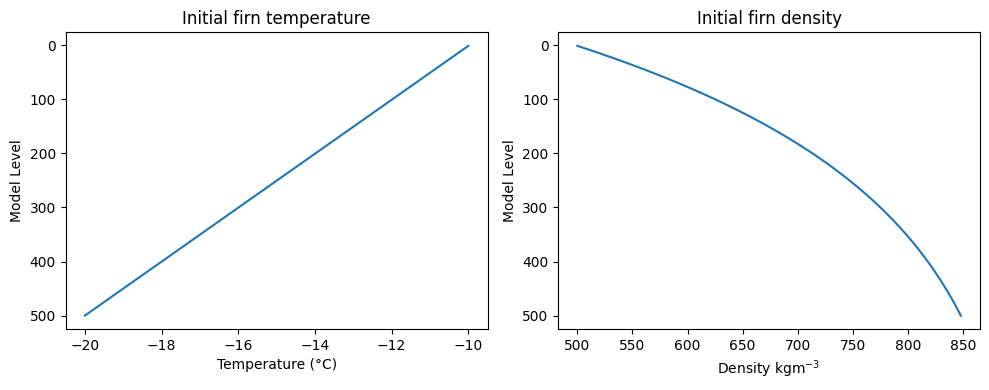

In [11]:
rho_sfc = 500
z_t  = 37
firn_depth = 35
vertical_points_firn = 500

T_init      = np.linspace(253.15, 263.15, vertical_points_firn)[::-1] # L108 initial_conditions.py
T_init_C    = T_init - 273.15  

z = np.linspace(0, firn_depth, vertical_points_firn)
rho = 917 - (917 - rho_sfc) * np.exp(-(1.9 / z_t) * z)  # L187 initial_conditions.py

time = np.arange(len(T_init))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

ax = axes[0]
ax.plot(T_init_C,range(1, vertical_points_firn + 1))
ax.set_title('Initial firn temperature')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Model Level')
ax.invert_yaxis()  

ax = axes[1]
ax.plot(rho,range(1, vertical_points_firn + 1))
ax.set_title('Initial firn density')
ax.set_xlabel('Density kgm$^{-3}$')
ax.set_ylabel('Model Level')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [12]:
met.close()
output.close()
dump.close()